In [1]:
from imaster_paper_args import *

Start_client: No scheduler file, will start local cluster at  ./temp_skylens/pid9573/


In [7]:
from astropy.io import fits
import os
import numpy as np
import matplotlib.pyplot as plt

import healpy as hp

import sys
sys.path.insert(0, '../skylens')
import correction
import pyccl as ccl

In [3]:
path = os.path.join(os.path.dirname(os.environ['SCRATCH']), 'shared')

In [4]:
i = 42
rot = 20
sims = list(sorted([os.path.join(path, sim) for sim in os.listdir(path) if f'r{i:03d}_rot{rot:02d}' in sim]))

In [5]:
sim_dict = {}
for i, sim in enumerate(sims):
    # Remove objects with z = -1
    sim = fits.open(sim)[1].data
    sim = sim[sim['z_source_mock'] != -1]
    sim = sim[(sim['shear1_sim'] ** 2 + sim['shear2_sim'] ** 2) <= 1.0]

    # Get z centers and boundary
    z = np.unique(sim['z_source_mock'])
    z_edges = 0.5 * (z[1:] + z[:-1])
    z_edges = np.concatenate([[0], z_edges, [np.max(z)+0.2]])
    dNdz, _ = np.histogram(sim['z_source_mock'], bins=z_edges, density=True)
    sim_dict[i] = {
        'z': z,
        'dNdz': dNdz,
        'ra': sim['ra_mock'],
        'dec': sim['dec_mock'],
        'e1': sim['e1_mock'],
        'e2': sim['e2_mock'],
        'g1': sim['shear1_sim'],
        'g2': sim['shear2_sim']
    }
sim_dict['n_bins'] = len(sim_dict)

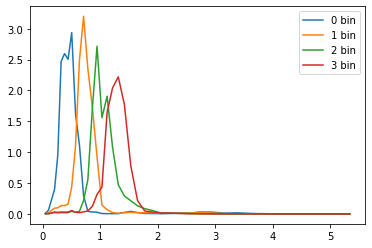

In [6]:
for b in range(sim_dict['n_bins']):
    sim = sim_dict[b]
    plt.plot(sim['z'], sim['dNdz'], label=f'{b} bin')
plt.legend()

In [14]:
nside = 1024
ell = np.arange(3 * nside)

cosmo = ccl.Cosmology(Omega_c=0.233, Omega_b=0.046, h=0.7, sigma8=0.82, n_s=0.97)

cl_theory = dict()
for i in range(sim_dict['n_bins']):
    for j in range(i, sim_dict['n_bins']):
        b = (i, j)
        lens_i = ccl.WeakLensingTracer(cosmo, dndz=(sim_dict[i]['z'], sim_dict[i]['dNdz']))
        lens_j = ccl.WeakLensingTracer(cosmo, dndz=(sim_dict[j]['z'], sim_dict[j]['dNdz']))
        cl_theory[b] = ccl.angular_cl(cosmo, lens_i, lens_j, ell)
        
nbins = 4

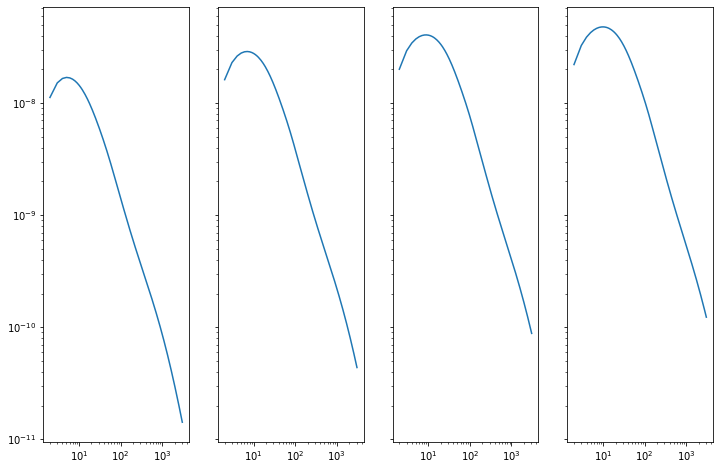

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=4, sharey='all', sharex=True, figsize=(12, 8))
for i in range(4):
    axs[i].loglog(ell[2:], cl_theory[(i, i)][2:])

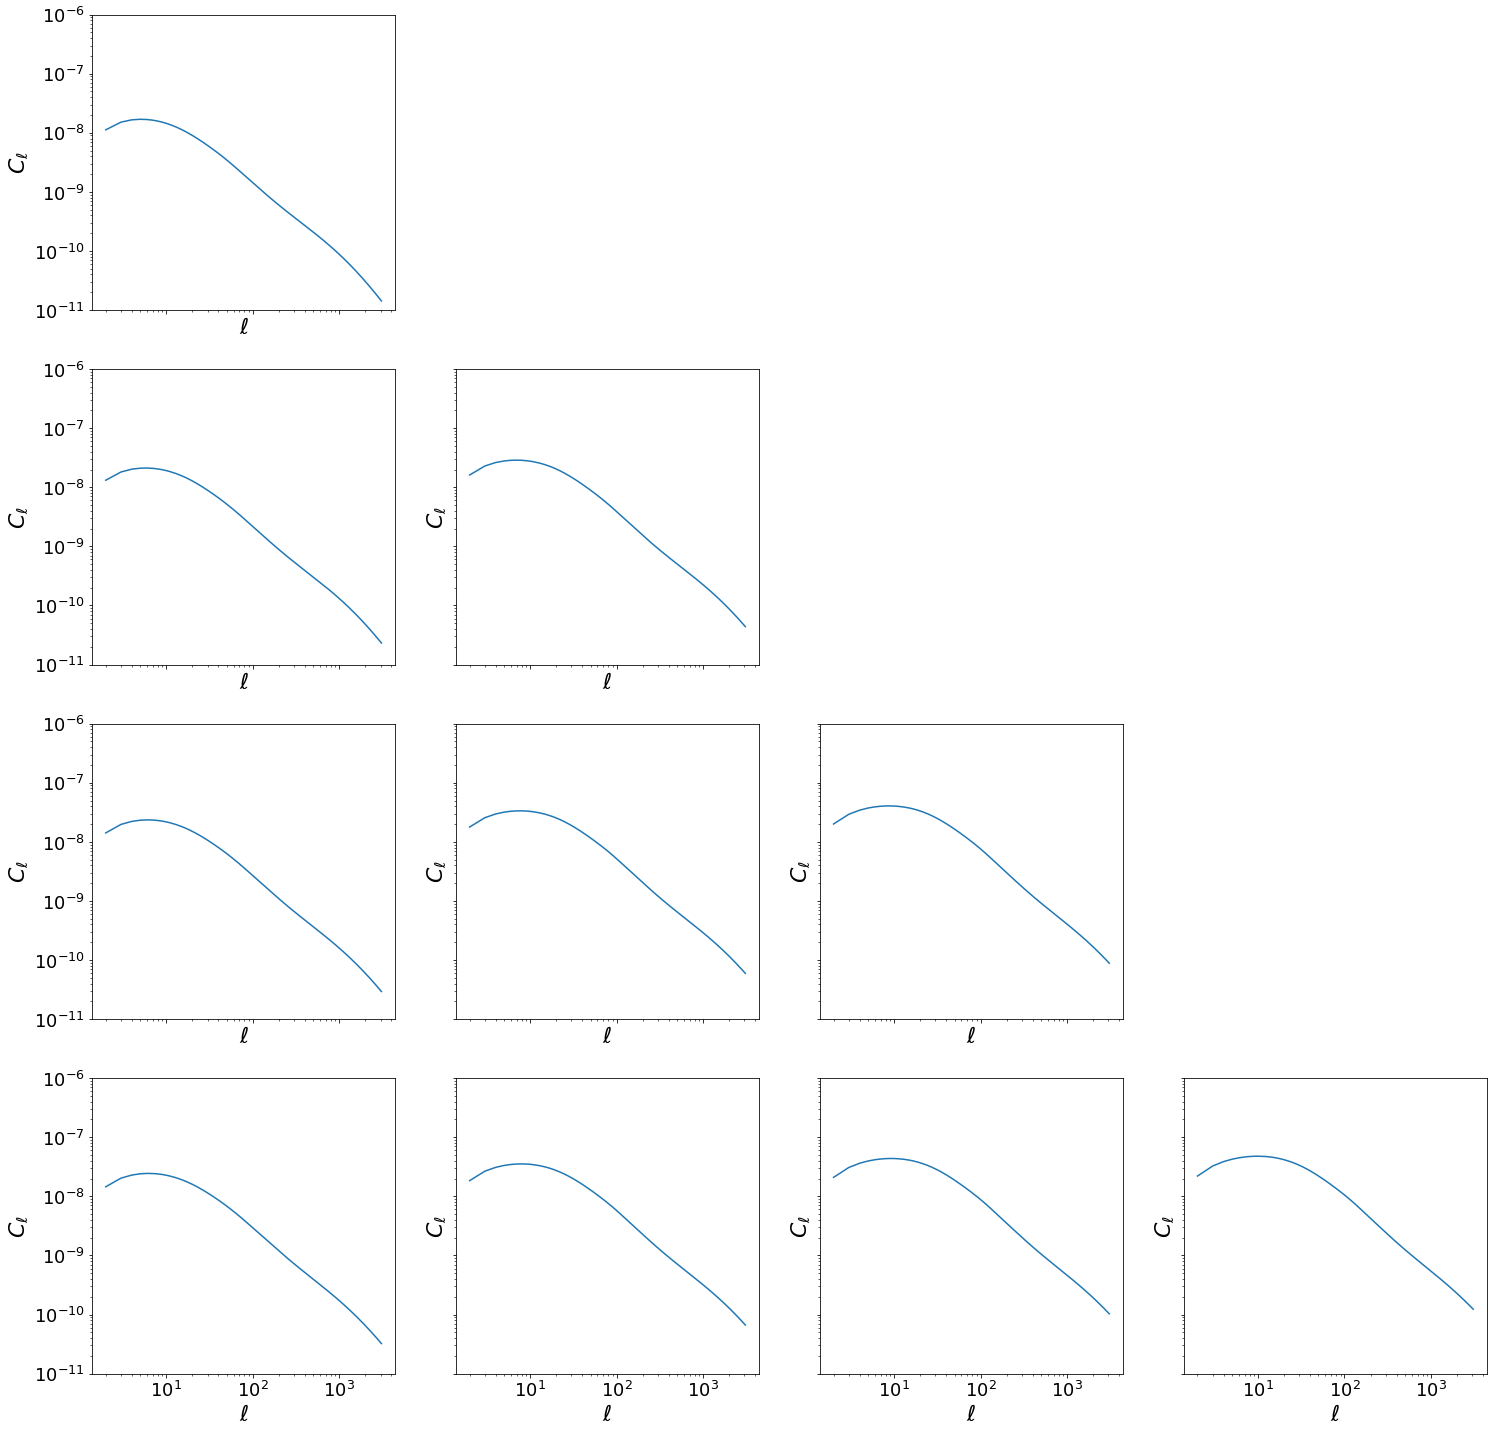

In [16]:
fig, axs = plt.subplots(nrows=nbins, ncols=nbins, sharey='all', sharex=True, figsize=(25, 25))
axs[0, 0].set_ylim((1e-11, 1e-6))
for i in range(nbins):
    for j in range(nbins):
        if j <= i:
            axs[i, j].loglog(ell[2:], cl_theory[(j, i)][2:])
            axs[i, j].set_xlabel(r'$\ell$', fontsize=22)
            axs[i, j].set_ylabel(r'$C_\ell$', fontsize=22)
            axs[i, j].tick_params(axis='both', labelsize=18)
        else:
            axs[i, j].axis('off')

# Pseudo_Cl

In [17]:
nside = 1024
npix = hp.nside2npix(nside)
pixels = dict()
for i in range(sim_dict['n_bins']):
    sim = sim_dict[i]
    pixels[i] = hp.ang2pix(nside, sim['ra'], sim['dec'], lonlat=True)

In [19]:
gamma1_maps = dict()
gamma2_maps = dict()
window = dict()

for i in range(nbins):
    sim = sim_dict[i]
    pixels = hp.ang2pix(nside, sim['ra'], sim['dec'], lonlat=True)
    gamma1_map = np.zeros(npix)
    gamma2_map = np.zeros(npix)
    counts_map = np.zeros(npix)
    
    gamma1_map[pixels] += sim['g1']
    gamma2_map[pixels] += sim['g2']
    uniq, counts = np.unique(pixels, return_counts=True)
    counts_map[uniq] = counts
    
    counts_mean = counts_map[counts_map > 0].mean()
    gamma1_map /= counts_mean
    gamma2_map /= counts_mean
    counts_map /= counts_mean
    
    gamma1_maps[i] = gamma1_map
    gamma2_maps[i] = gamma2_map
    window[i] = counts_map

In [20]:
pcl_dict = dict()
for i in range(nbins):
    for j in range(i, nbins):
        imap_1, imap_2 = gamma1_maps[i], gamma2_maps[i]
        jmap_1, jmap_2 = gamma1_maps[j], gamma2_maps[j]
        iargs = [imap_1 * 0, imap_1, imap_2]
        jargs = [jmap_1 * 0, jmap_1, jmap_2]
        pcl_dict[(i, j)] = hp.sphtfunc.anafast(iargs, jargs, pol=True)

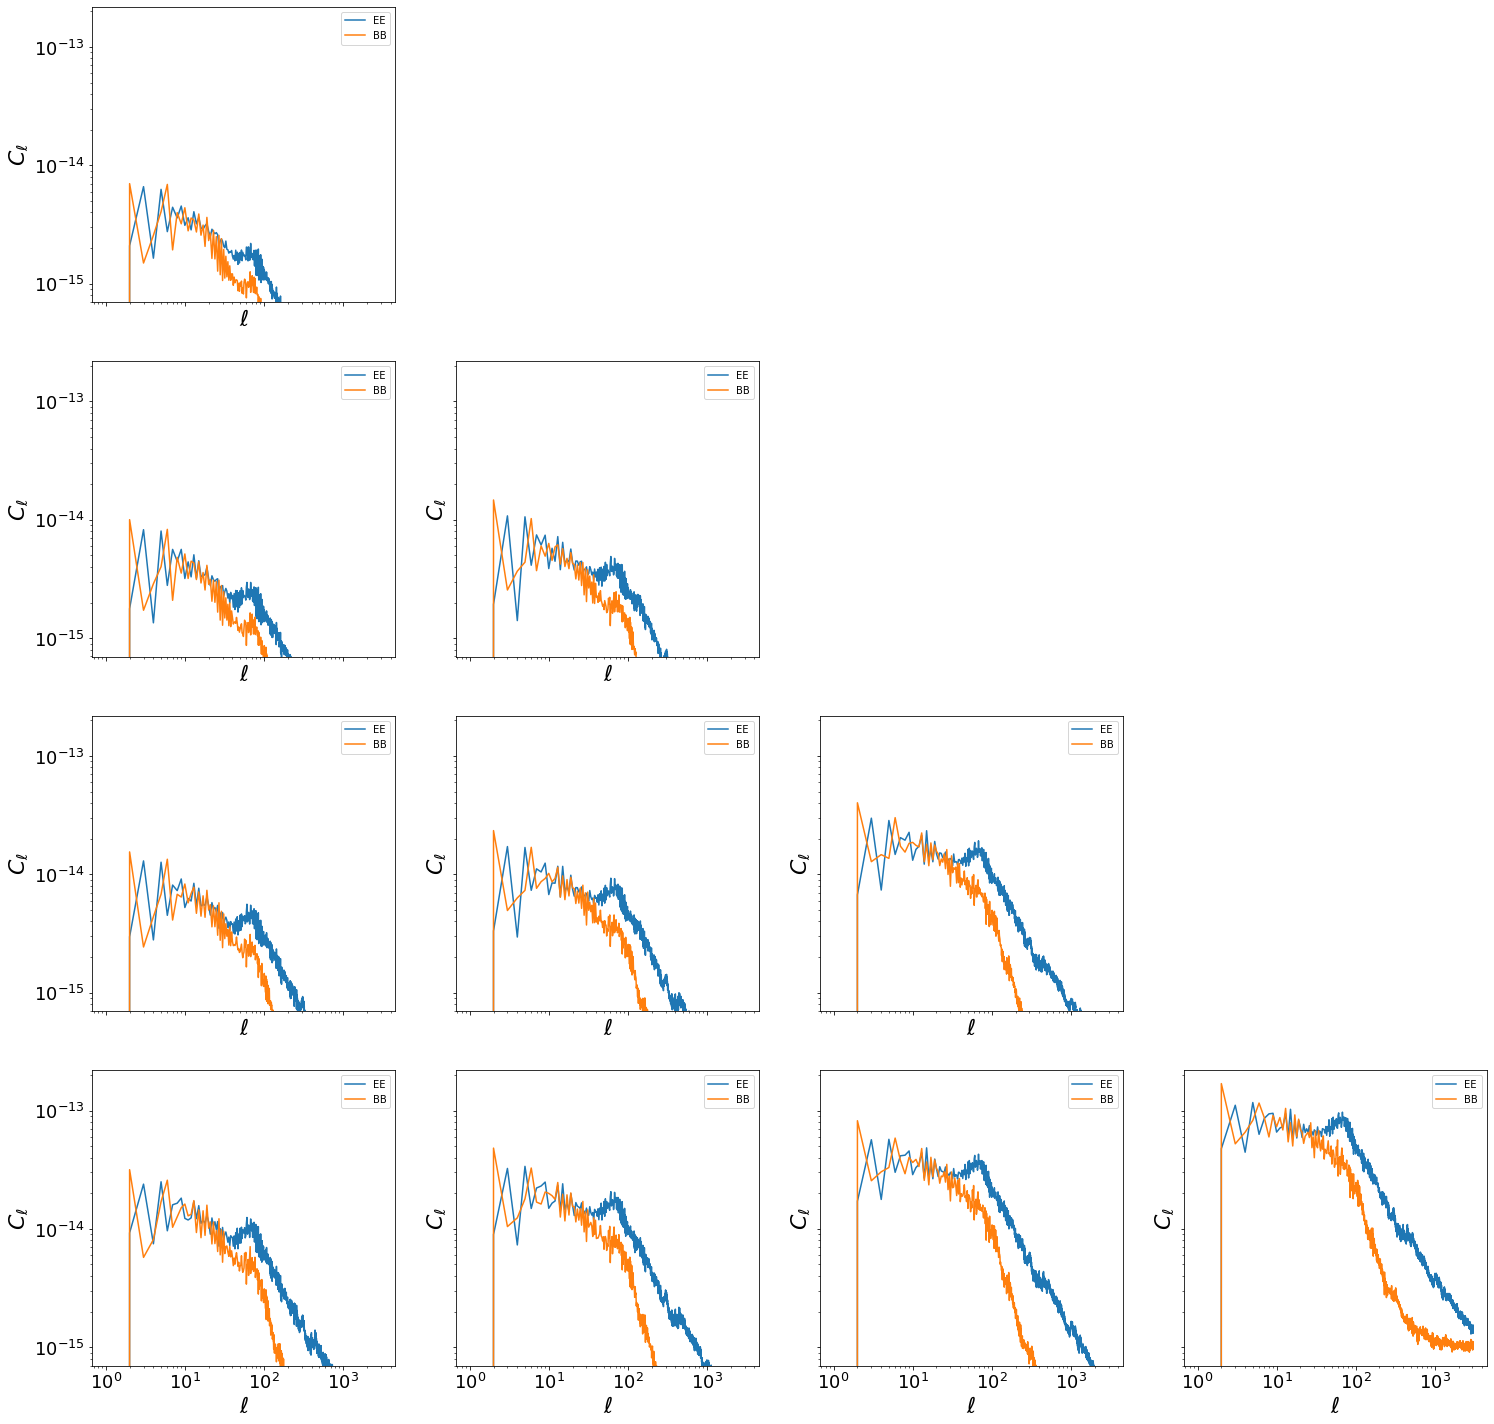

In [22]:
fig, axs = plt.subplots(nrows=nbins, ncols=nbins, sharey='all', sharex=True, figsize=(25, 25))
for i in range(nbins):
    for j in range(nbins):
        if j <= i:
            axs[i, j].loglog(ell, pcl_dict[(j, i)][1], label='EE')
            axs[i, j].loglog(ell, pcl_dict[(j, i)][2], label='BB')
            axs[i, j].set_xlabel(r'$\ell$', fontsize=22)
            axs[i, j].set_ylabel(r'$C_\ell$', fontsize=22)
            axs[i, j].tick_params(axis='both', labelsize=18)
            axs[i, j].legend()
        else:
            axs[i, j].axis('off')

In [23]:
# HSC coverage is 1400 sq deg.
full_sky = 4 * np.pi * (180 / np.pi) ** 2
f_sky = 137. / (full_sky)

In [24]:
use_window=True
unit_window=False

do_pseudo_cl=True
do_xi=False

bin_cl=True
bin_xi=True

use_binned_l=False
use_binned_theta=False

store_win=True

In [25]:
shear_zbins=lsst_source_tomo_bins(nbins=nbins,use_window=use_window,nside=nside,f_sky=f_sky,unit_win=unit_window)

ns0:  27.0
[0.10002001 0.10082017 0.10162032 ... 2.9981997  2.9989998  2.9998    ] 100 5
source_tomo_bins, zmax 5.0 2.9998 0.59997
Tracer utils has no tracers
skylens will use following default values:  {'yaml_inp_file': None, 'python_inp_file': None, 'l_cl': None, 'Ang_PS': None, 'logger': None, 'tracer_utils': None, 'kappa_zbins': None, 'galaxy_zbins': None, 'zkernel_func_names': {'shear': 'set_kernel', 'galaxy': 'set_kernel', 'kappa': 'set_kernel'}, 'pk_params': {'non_linear': 1, 'kmax': 30, 'kmin': 0.0003, 'nk': 500, 'scenario': 'dmo', 'pk_func': 'camb_pk_too_many_z', 'halofit_version': 'takahashi'}, 'cosmo_params': {'h': 0.7, 'Omb': 0.046, 'Omd': 0.233, 's8': 0.82, 'Om': 0.279, 'Ase9': 2.1842, 'mnu': 0.0, 'Omk': 0.0, 'tau': 0.06, 'ns': 0.97, 'OmR': 0.0014936944554559178, 'w': -1, 'wa': 0, 'Tcmb': <Quantity 2.7255 K>, 'z_max': 4, 'use_astropy': True, 'Oml': 0.721, 'astropy_cosmo': FlatLambdaCDM(name="Planck18", H0=67.66 km / (Mpc s), Om0=0.30966, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0

/jet/home/andypark/.local/lib/python3.9/site-packages/skylens-0.1-py3.9.egg/skylens/angular_power_spectra.py:33: RuntimeWarning: divide by zero encountered in true_divide


power spectra function:  <bound method Power_Spectra.camb_pk_too_many_z of <skylens.power_spectra.Power_Spectra object at 0x14a6767e4f10>>
Win gen: step size 153 3072 31.0 10 False True
Window done. Size: 0.0


/jet/home/andypark/.local/lib/python3.9/site-packages/skylens-0.1-py3.9.egg/skylens/angular_power_spectra.py:123: RuntimeWarning: divide by zero encountered in true_divide


scatter_dict got empty dictionary
cl_tomo, Win: None
cl graph done
gather_dict got empty dictionary


/ocean/projects/phy210065p/andypark/miniconda3/envs/skylite/lib/python3.9/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=bool. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


In [26]:
for i in range(sim_dict['n_bins']):
    sim = sim_dict[i]
    shear_zbins[i]['z'] = sim['z']
    shear_zbins[i]['dz'] = np.gradient(sim['z'])
    shear_zbins[i]['pz'] = sim['dNdz']
    shear_zbins[i]['pzdz'] = sim['dNdz'] * np.gradient(sim['z'])
    shear_zbins[i]['window'] = window[i]
    shear_zbins[i]['window_N'] = np.sqrt(window[i])

In [28]:
#setup parameters
#lmax_cl = 3*nside #2000
lmax_cl = 2200
lmin_cl = 0

l0 = np.arange(lmin_cl, lmax_cl)

window_lmax = lmax_cl

lmin_cl_Bins = 200 #lmin_cl+2
lmax_cl_Bins = lmax_cl - 10
Nl_bins = 11

#l_bins = np.unique(np.int64(np.logspace(np.log10(lmin_cl_Bins), np.log10(lmax_cl_Bins), Nl_bins+1)))
#l_bins = np.arange(lmin_cl_Bins, lmax_cl_Bins, Nl_bins)
l_bins = np.linspace(lmin_cl_Bins, lmax_cl_Bins, Nl_bins)
lb = .5 * (l_bins[1:] + l_bins[:-1])
dl = (l_bins[1:] - l_bins[:-1])
lb_cl = lb * 1.
l_bins_center = lb * 1.
Nl_bins = len(lb)

l = l0

In [29]:
Skylens_kwargs=parse_dict(locals())

Skylens_kwargs['do_pseudo_cl']=True
Skylens_kwargs['do_xi']=False
SL_cl0=Skylens(**Skylens_kwargs)

skylens will use following default values:  {'yaml_inp_file': None, 'python_inp_file': None, 'use_defaults': None, 'l_cl': None, 'Ang_PS': None, 'logger': None, 'kappa_zbins': None, 'galaxy_zbins': None, 'zkernel_func_names': {'shear': 'set_kernel', 'galaxy': 'set_kernel', 'kappa': 'set_kernel'}, 'pk_params': {'non_linear': 1, 'kmax': 30, 'kmin': 0.0003, 'nk': 500, 'scenario': 'dmo', 'pk_func': 'camb_pk_too_many_z', 'halofit_version': 'takahashi'}, 'cosmo_params': {'h': 0.7, 'Omb': 0.046, 'Omd': 0.233, 's8': 0.82, 'Om': 0.279, 'Ase9': 2.1842, 'mnu': 0.0, 'Omk': 0.0, 'tau': 0.06, 'ns': 0.97, 'OmR': 0.0014936944554559178, 'w': -1, 'wa': 0, 'Tcmb': <Quantity 2.7255 K>, 'z_max': 4, 'use_astropy': True, 'Oml': 0.721, 'astropy_cosmo': FlatLambdaCDM(name="Planck18", H0=67.66 km / (Mpc s), Om0=0.30966, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.04897)}, 'WT_kwargs': None, 'WT': None, 'z_PS': None, 'log_z_PS': 2, 'window_l': None, 'Win': None, 'cl_func_names': {('shear', 'shear

/jet/home/andypark/.local/lib/python3.9/site-packages/skylens-0.1-py3.9.egg/skylens/angular_power_spectra.py:33: RuntimeWarning: divide by zero encountered in true_divide


power spectra function:  <bound method Power_Spectra.camb_pk_too_many_z of <skylens.power_spectra.Power_Spectra object at 0x14adde310970>>
Win gen: step size 100 2200 2201.0 1 True True
Win not found, computing now
get_Win, total cl keys:  10
set window_cl: cl0,cl_b done 5.984306335449219e-05
set window_cl: cl done 0.013458013534545898 0.074 0.0
set_window_cl done 172.65339398384094
wigner_files: {0: '/ocean/projects/phy210065p/andypark/skylens_lite/temp/wig3j_l5000_w5000_0_reorder.zarr', 2: '/ocean/projects/phy210065p/andypark/skylens_lite/temp/wig3j_l5000_w7000_2_reorder.zarr'}
wigner done dict_keys([])
setting windows, coupling matrices  <Client: 'tcp://127.0.0.1:46553' processes=1 threads=1, memory=186.26 GiB>
get_coupling_lm_all_win 0
got wig3j 0
done lm 0 17.01432776451111
get_coupling_lm_all_win 1200
got wig3j 1200
done lm 1200 17.23208451271057
get_coupling_lm_all_win 1500
got wig3j 1500
done lm 1500 19.310718297958374
get_coupling_lm_all_win 600
got wig3j 600
done lm 600 18.10

In [30]:
SL_cl0.gather_data()

gather_dict got empty dictionary


In [33]:
cl_sl_ee = dict()
cl_sl_bb = dict()
cl_ee_binned = dict()
cl_bb_binned = dict()
bu = SL_cl0.cl_bin_utils
cl_ee = {i: cl_theory[(i, i)] for i in range(4)}
cl_bb = {i: 0 * cl_theory[(i, i)] for i in range(4)}
for i in range(4):
    bi = (i, i)
    Mp = SL_cl0.Win['cl'][corr_ll][bi]['M']
    Mn = SL_cl0.Win['cl'][corr_ll][bi]['M_B']
    pcl_ee = pcl_dict[bi][1]
    pcl_bb = pcl_dict[bi][2]
    
    binned_pcl_ee = SL_cl0.binning.bin_1d(pcl_ee[:lmax_cl], bin_utils=bu)
    binned_pcl_bb = SL_cl0.binning.bin_1d(pcl_bb[:lmax_cl], bin_utils=bu)
    binned_cl_ee = SL_cl0.binning.bin_1d(cl_ee[i][:lmax_cl], bin_utils=bu)
    binned_cl_bb = SL_cl0.binning.bin_1d(cl_bb[i][:lmax_cl], bin_utils=bu)
    
    cl_ee_binned[i] = binned_cl_ee
    cl_bb_binned[i] = binned_cl_bb
    
    wt0_ee = 1. / cl_ee[i][:lmax_cl]
    wt0_bb = 1. / cl_bb[i][:lmax_cl]
    wt0_ee[:2] = 0
    wt0_bb[:] = 0
    
    Mp_binned_ee = SL_cl0.binning.bin_2d_coupling(M=Mp, bin_utils=bu, wt_b=binned_cl_ee, wt0=wt0_ee)
    Mp_binned_bb = SL_cl0.binning.bin_2d_coupling(M=Mp, bin_utils=bu, wt_b=binned_cl_bb, wt0=wt0_bb)
    
    Mn_binned_ee = SL_cl0.binning.bin_2d_coupling(M=Mn, bin_utils=bu, wt_b=binned_cl_ee, wt0=wt0_ee)
    Mn_binned_bb = SL_cl0.binning.bin_2d_coupling(M=Mn, bin_utils=bu, wt_b=binned_cl_bb, wt0=wt0_bb)
    
    cl_sl_ee[i] = binned_pcl_ee @ np.linalg.pinv(Mp_binned_ee)# - binned_cl_bb @ (np.linalg.pinv(Mp_binned_ee) @ Mn_binned_bb)
    cl_sl_bb[i] = binned_pcl_bb @ np.linalg.pinv(Mp_binned_bb)# - binned_cl_ee @ (np.linalg.pinv(Mp_binned_bb) @ Mn_binned_ee)

/tmp/ipykernel_9573/552325830.py:23: RuntimeWarning: divide by zero encountered in true_divide
  wt0_ee = 1. / cl_ee[i][:lmax_cl]
/tmp/ipykernel_9573/552325830.py:24: RuntimeWarning: divide by zero encountered in true_divide
  wt0_bb = 1. / cl_bb[i][:lmax_cl]


# Comparing D_l_data vs f_sky * C_l_theory

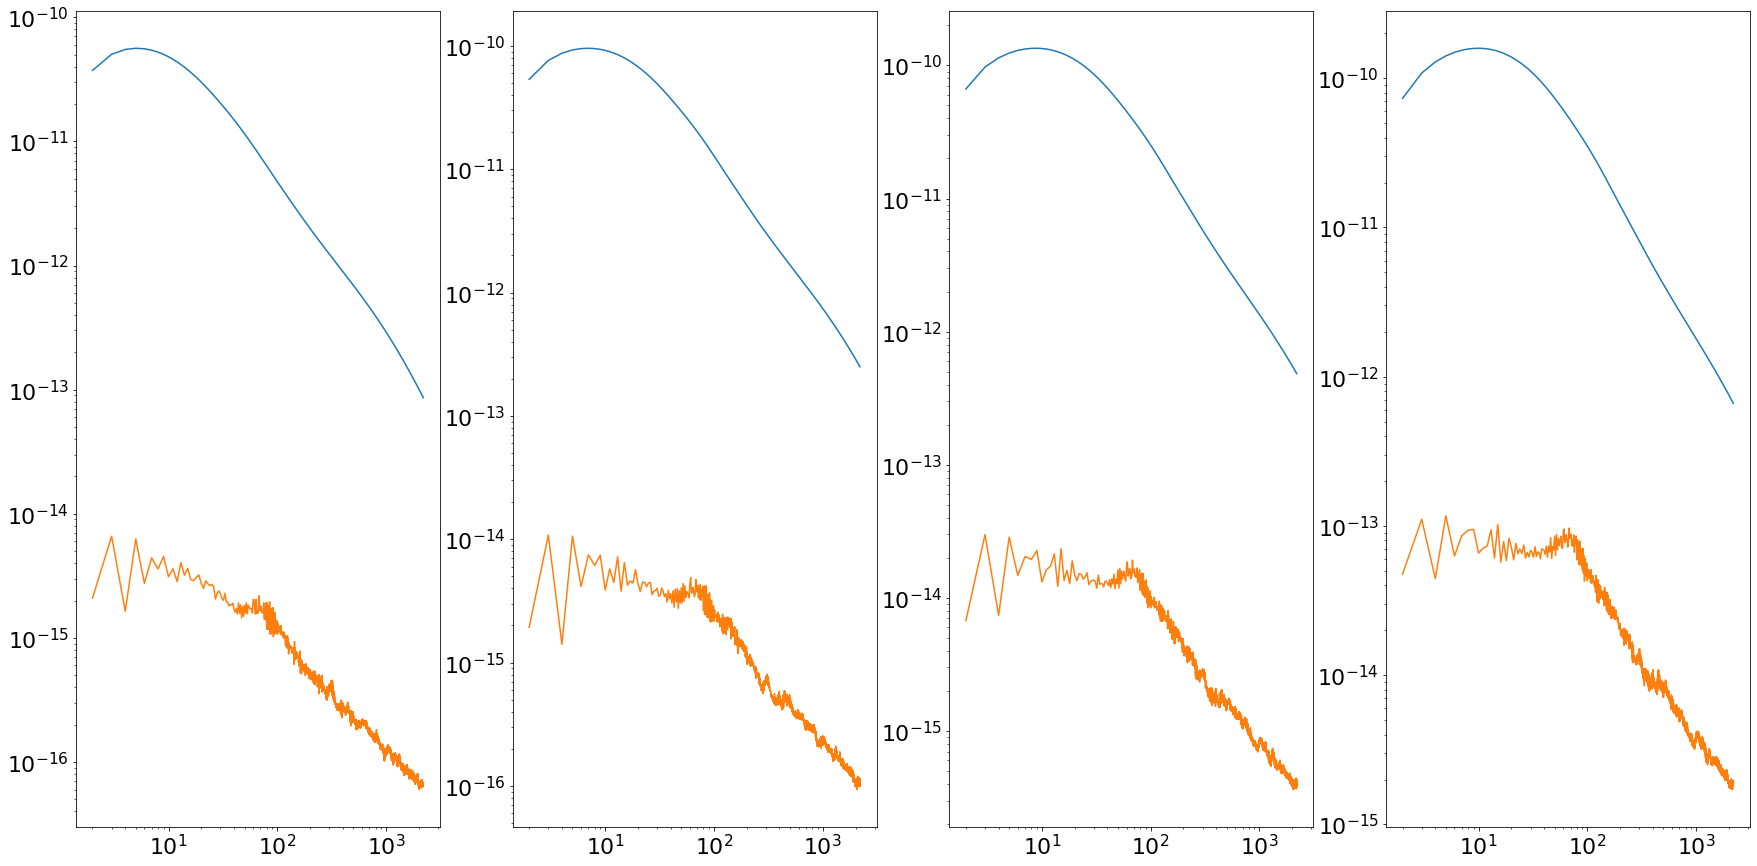

In [37]:
bc = bc = 0.5 * (SL_cl0.l_bins[1:] + SL_cl0.l_bins[:-1])
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(30, 15))
for i in range(4):
    bi = (i, i)
    Mp = SL_cl0.Win['cl'][corr_ll][bi]['M']
    pcl_reconstructed = cl_ee[i][:lmax_cl] @ Mp
    axs[i].loglog(ell[2:lmax_cl], cl_ee[i][2:lmax_cl] * f_sky)
    axs[i].loglog(ell[2:lmax_cl], pcl_dict[bi][1][2:lmax_cl])
    axs[i].tick_params(axis='both', which='major', labelsize=22)
    axs[i].tick_params(axis='both', which='minor', labelsize=10)

# Comparing D_l_data vs M @ C_l_theory

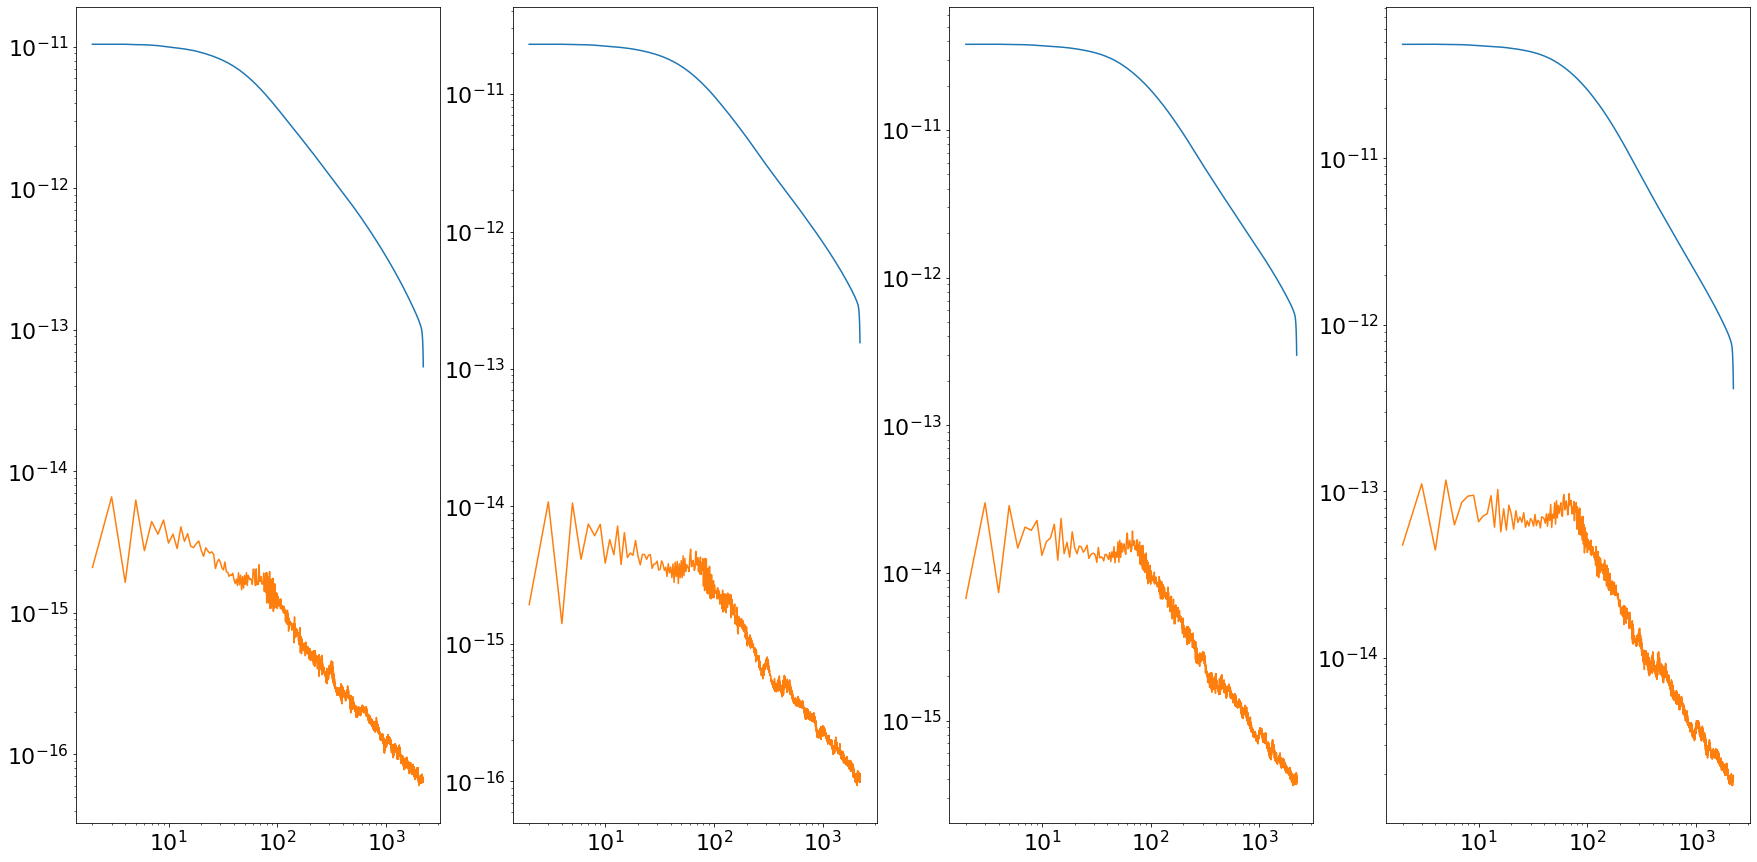

In [38]:
bc = bc = 0.5 * (SL_cl0.l_bins[1:] + SL_cl0.l_bins[:-1])
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(30, 15))
for i in range(4):
    bi = (i, i)
    Mp = SL_cl0.Win['cl'][corr_ll][bi]['M']
    pcl_reconstructed = cl_ee[i][:lmax_cl] @ Mp
    axs[i].loglog(ell[2:lmax_cl], pcl_reconstructed[2:])
    axs[i].loglog(ell[2:lmax_cl], pcl_dict[bi][1][2:lmax_cl])
    axs[i].tick_params(axis='both', which='major', labelsize=22)
    axs[i].tick_params(axis='both', which='minor', labelsize=10)